In [1]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

### Data loading and pre-processing

In [2]:
Data = pd.read_csv('SalesData.csv')

In [3]:
Data = Data.drop('Unnamed: 0', axis =1)
Data['Profit'] = (Data['SellPrice'] - Data['COGS']) * Data['SellQty'] 
Data['TransactionDate'] = pd.to_datetime(Data['TransactionDate'])

In [4]:
Data['TransNo'] = Data['TransNo'].astype(str)
Data['CustomerNo'] = Data['CustomerNo'].astype(str)
Data['SubCategory'] = Data['SubCategory'].astype(str)

In [5]:
#Dropping transaction lines with less than 0 Selling Price and negative SellQty
Data = Data[(Data.SellPrice > 0) & (Data.SellQty >= 0)]

In [6]:
#Data['TransMonth'] = Data['TransactionDate'].dt.to_period('M')

### Data Overview

In [7]:
Data.shape

(2156625, 11)

In [8]:
Data.head()

,TransNo,TransLine,CustomerNo,Category,SubCategory,TransactionDate,SellPrice,SellQty,COGS,Part,Profit
0,4515542,4,80000,CAT3002,430,2015-01-02,25.01,0.0,19.899,P140PA780,0.000
1,4516499,3,80000,CAT3002,430,2015-01-05,25.01,1.0,20.295,P140PA780,4.715
2,4516508,3,80000,CAT3002,430,2015-01-05,25.01,1.0,20.295,P140PA780,4.715
3,4516509,4,80000,CAT3002,430,2015-01-05,25.01,1.0,20.295,P140PA780,4.715
4,4517969,10,32965,CAT3002,430,2015-01-06,23.28,2.0,19.899,P140PA780,6.762


In [9]:
Data.dtypes

TransNo                    object
TransLine                   int64
CustomerNo                 object
Category                   object
SubCategory                object
TransactionDate    datetime64[ns]
SellPrice                 float64
SellQty                   float64
COGS                      float64
Part                       object
Profit                    float64
dtype: object

In [10]:
#unique values in each column
def unique_counts(df):
   for i in df.columns:
       count = df[i].nunique()
       print(i, ":", count)

unique_counts(Data)

TransNo : 321754
TransLine : 894
CustomerNo : 1305
Category : 14
SubCategory : 295
TransactionDate : 890
SellPrice : 31340
SellQty : 575
COGS : 30587
Part : 42295
Profit : 193552


In [11]:
Data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,TransLine,SellPrice,SellQty,COGS,Profit
count,2.15662e+06,2.15662e+06,2.15662e+06,2.15662e+06,2.15662e+06
mean,20.4193,27.4894,13.2433,19.1082,24.5527
std,30.6311,74.7268,109.626,55.5466,112.807
min,1,0.01,0,-0.1,-9434
25%,3,2.87,1,1.591,2.7
50%,11,7.74,2,4.75,8.592
75%,25,27.09,8,18.77,23
max,894,12000,20000,9580.87,27750


In [12]:
Data['TransactionDate'].max() - Data['TransactionDate'].min() 

Timedelta('1021 days 00:00:00')

## Monthly Transactions based Exploratory Analysis
Time series visuals

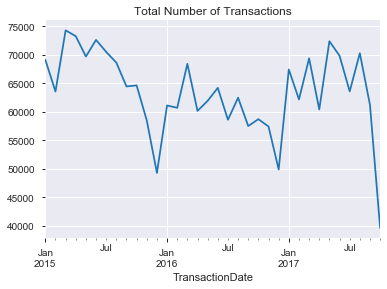

In [13]:
Data.groupby([Data['TransactionDate'].dt.to_period('M')]).size().plot()
plt.title('Total Number of Transactions')
plt.show()

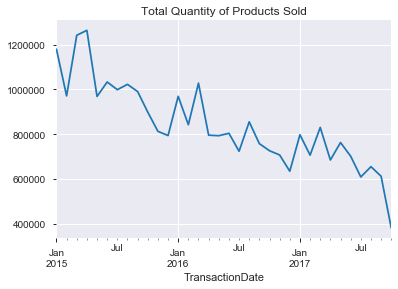

In [14]:
Data.groupby([Data['TransactionDate'].dt.to_period('M')])['SellQty'].sum().plot()
plt.title('Total Quantity of Products Sold')
plt.show()

The above graph shows we are selling lesser products but the profit is increasing in the last year. That could mean, we are focusing on higher profit products.

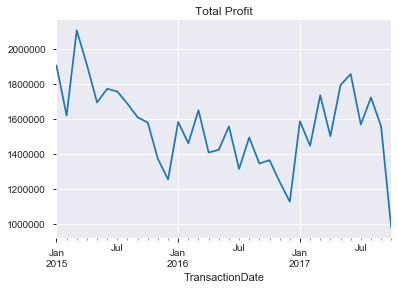

In [15]:
Data.groupby([Data['TransactionDate'].dt.to_period('M')])['Profit'].sum().plot()
plt.title('Total Profit')
plt.show()

There is a drop in the Month of December, which is surprising. As everyone is buying gifts and spending a lot during Christmas.

Another important observation is the total number of products sold is decreasing over time, but we have managed to bounce back the Profit after a bad year of 2016.
Maybe we are getting rid of the products with low profit.

## Customer analysis - RFM Segmentation

In [16]:
Data.head()

,TransNo,TransLine,CustomerNo,Category,SubCategory,TransactionDate,SellPrice,SellQty,COGS,Part,Profit
0,4515542,4,80000,CAT3002,430,2015-01-02,25.01,0.0,19.899,P140PA780,0.000
1,4516499,3,80000,CAT3002,430,2015-01-05,25.01,1.0,20.295,P140PA780,4.715
2,4516508,3,80000,CAT3002,430,2015-01-05,25.01,1.0,20.295,P140PA780,4.715
3,4516509,4,80000,CAT3002,430,2015-01-05,25.01,1.0,20.295,P140PA780,4.715
4,4517969,10,32965,CAT3002,430,2015-01-06,23.28,2.0,19.899,P140PA780,6.762


In [17]:
RFM_df = pd.DataFrame({
    'Days_Since_Visit' : (Data['TransactionDate'].max() - Data.groupby('CustomerNo')['TransactionDate'].max()).dt.days,
    'TotalVisits' : Data.groupby(['CustomerNo'])['TransNo'].nunique(),
    'TotalProfit' : Data.groupby(['CustomerNo'])['Profit'].sum()
    })
RFM_df

,Days_Since_Visit,TotalVisits,TotalProfit
CustomerNo,,,
10000,110,17,7239.690
10012,71,9,1288.742
10028,30,67,14996.707
10051,13,146,34705.234
100581,0,222,56479.929
...,...,...,...
9250,20,37,2903.570
93277,2,36,22792.865
9405,47,13,2256.381


In [18]:
quantiles = RFM_df.quantile(q=[0.25,0.5,0.75]).to_dict()

In [19]:
quantiles

{'Days_Since_Visit': {0.25: 5.0, 0.5: 20.0, 0.75: 153.0},
 'TotalProfit': {0.25: 1387.388, 0.5: 8236.423, 0.75: 29703.455999999962},
 'TotalVisits': {0.25: 9.0, 0.5: 46.0, 0.75: 134.0}}

In [20]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [21]:
RFM_df['r_quartile'] = RFM_df['Days_Since_Visit'].apply(RScore, args=('Days_Since_Visit',quantiles,))
RFM_df['f_quartile'] = RFM_df['TotalVisits'].apply(FMScore, args=('TotalVisits',quantiles,))
RFM_df['m_quartile'] = RFM_df['TotalProfit'].apply(FMScore, args=('TotalProfit',quantiles,))

In [22]:
RFM_df['RFMScore'] = RFM_df.r_quartile.map(str) + RFM_df.f_quartile.map(str) + RFM_df.m_quartile.map(str)

In [23]:
RFM_df.head()

,Days_Since_Visit,TotalVisits,TotalProfit,r_quartile,f_quartile,m_quartile,RFMScore
CustomerNo,,,,,,,
10000,110,17,7239.690,3,3,3,333
10012,71,9,1288.742,3,4,4,344
10028,30,67,14996.707,3,2,2,322
10051,13,146,34705.234,2,1,1,211
100581,0,222,56479.929,1,1,1,111


In [24]:
#RFM_df.reset_index().to_csv('RFM.csv', index=False)

** Tableau Viz for Interacting with Customer Segments: **   
https://public.tableau.com/profile/suraj.malpani#!/vizhome/CustomerSegmentation_15755893101840/Sheet1

Filtered out customers with RFM Score of 111 from the above Viz.

** Customers who are inactive since a while, i.e. are in r_quartile = 4 are basically churned customers. **

In [25]:
RFM_df[RFM_df.r_quartile.isin(['4'])]

,Days_Since_Visit,TotalVisits,TotalProfit,r_quartile,f_quartile,m_quartile,RFMScore
CustomerNo,,,,,,,
10129,874,2,39.971,4,4,4,444
10131,378,5,635.268,4,4,4,444
101624,230,2,135.347,4,4,4,444
10222,168,3,302.880,4,4,4,444
10259,308,80,2968.081,4,2,3,423
...,...,...,...,...,...,...,...
86272,980,1,50.190,4,4,4,444
90060,1001,1,384.178,4,4,4,444
90237,184,1,48.900,4,4,4,444


## Product based analysis
Which Products/categories are most profitable?

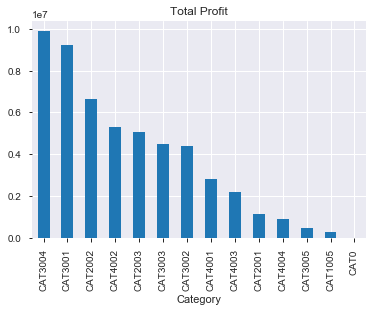

In [26]:
Data.groupby(['Category'])['Profit'].sum().sort_values(ascending=False).plot.bar()
plt.title('Total Profit')
plt.show()

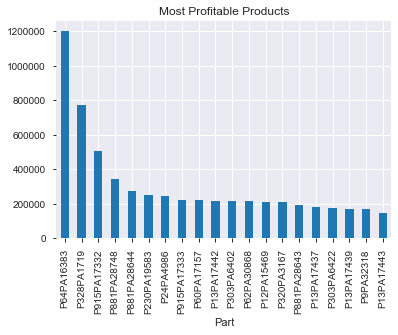

In [27]:
Data.groupby(['Part'])['Profit'].sum().sort_values(ascending=False).head(20).plot.bar()
plt.title('Most Profitable Products')
plt.show()

** Tableau Visuals to interact with Product/category wise profit. **  
https://public.tableau.com/views/Profitsovertime_15756023975480/Dashboard1?:display_count=y&publish=yes&:origin=viz_share_link

** IBM Watson Dashboard **  
https://dataplatform.cloud.ibm.com/dashboards/efab7c1f-ca3c-444c-ac49-0260b37b345a/view/6506b80c1d806ac75cc0c0e407907f577a372708b0bbd00583837b4909637297a93c4792c87d425ad9150160a1b8150b9b 


### Did free Samples made them buy more products over other customers?

In [28]:
Data['Free_Sample'] = np.where(Data['SellQty'] == 0, 1, 0)

In [29]:
Data.groupby(['Part'])['Free_Sample'].sum().sort_values()

Part
P3035PA24352       0
P380PA14446        0
P380PA14406        0
P822PA6330         0
P6952PA26611       0
                ... 
P115PA11460     1031
P2330PA9482     1057
P499PA1521      1236
P380PA11984     1305
P9PA32318       1401
Name: Free_Sample, Length: 42295, dtype: int32

In [30]:
Data.groupby(['CustomerNo','Part'])['Free_Sample'].sum().sort_values()

CustomerNo  Part       
10000       P113PA13263      0
46652       P18PA27078       0
            P18PA27065       0
            P18PA27063       0
            P18PA27061       0
                          ... 
79500       P115PA11460    649
            P2330PA9482    748
            P499PA1521     814
            P380PA11984    814
            P9PA32318      846
Name: Free_Sample, Length: 390792, dtype: int32

In [31]:
free_df = Data[Data['Free_Sample'] == 1][['CustomerNo','Part']].drop_duplicates()
free_df

,CustomerNo,Part
0,80000,P140PA780
5,80001,P140PA780
8,64372,P140PA780
84,10421,P140PA780
285,19225,P140PA780
...,...,...
2200729,13012,P555PA40964
2200779,50891,P555PA40994
2200908,22057,P555PA41082
2200991,22057,P555PA41142


In [32]:
from scipy.stats import ttest_ind
from scipy.stats import levene

In [33]:
levene(Data[((Data['CustomerNo'].isin(free_df['CustomerNo']))&(Data['Part'].isin(free_df['Part'])))]['SellQty'],
          Data[~((Data['CustomerNo'].isin(free_df['CustomerNo']))&(Data['Part'].isin(free_df['Part'])))]['SellQty'])

LeveneResult(statistic=22.055647996796715, pvalue=2.6487546868526574e-06)

No equal variance thus Welch's t-test (independent samples).

In [34]:
ttest_ind(Data[((Data['CustomerNo'].isin(free_df['CustomerNo']))&(Data['Part'].isin(free_df['Part'])))]['SellQty'],
          Data[~((Data['CustomerNo'].isin(free_df['CustomerNo']))&(Data['Part'].isin(free_df['Part'])))]['SellQty'],
          equal_var = False)

Ttest_indResult(statistic=-4.144954483856496, pvalue=3.4008023782384946e-05)

In [35]:
Data[((Data['CustomerNo'].isin(free_df['CustomerNo']))&(Data['Part'].isin(free_df['Part'])))]['SellQty'].mean()

13.139675486323691

In [36]:
Data[~((Data['CustomerNo'].isin(free_df['CustomerNo']))&(Data['Part'].isin(free_df['Part'])))]['SellQty'].mean()

14.842429034101734

** This means that providing free samples doesn't necessarily make customers buy more products.  
Else, the assumption that SellQty = 0 means free sample is incorrect. **

In [37]:
Data = Data.drop('Free_Sample', axis = 1)

## Recommendations based on Apriori
Which Category/Subcategories should be kept next to each other in the aisles.

**Analyzing by 'Part' failed. So trying with SubCategory! **

In [38]:
temp_df = Data.groupby(['TransNo', 'SubCategory'])['SellQty'].sum().unstack().reset_index().fillna(0).set_index('TransNo')
temp_df

SubCategory,430,431,432,433,434,435,436,437,438,439,...,715,716,717,718,719,720,721,722,723,724
TransNo,,,,,,,,,,,,,,,,,,,,,
30,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4515332,0.0,1.0,50.0,1.0,3.0,0.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4515333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4515337,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4515343,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80000804,0.0,0.0,0.0,0.0,50.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80000805,38.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80000859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#Function for hot-encoding
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [40]:
Apr_df = temp_df.applymap(hot_encode)
del temp_df

In [41]:
Apr_df = Apr_df.fillna(0)

In [42]:
# Building the model 
frq_items = apriori(Apr_df, min_support = 0.05, use_colnames = True) 
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

In [60]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False)

,antecedents,consequents,support,confidence,lift
13,(437),"(461, 433)",0.051235,0.516739,6.021831
12,"(461, 433)",(437),0.051235,0.597066,6.021831
11,"(437, 433)",(461),0.051235,0.756887,5.392278
14,(461),"(437, 433)",0.051235,0.365011,5.392278
10,"(461, 437)",(433),0.051235,0.903238,4.997945
15,(433),"(461, 437)",0.051235,0.283501,4.997945
9,(437),(461),0.056723,0.572096,4.075772
8,(461),(437),0.056723,0.404114,4.075772
2,(433),(455),0.057013,0.315471,4.020916
3,(455),(433),0.057013,0.726668,4.020916


** These Product Categories should be placed near to each other! **  
The Customers who bought antecedent are more likely to buy consequesent.

* Support: Percentage of total transactions with that product.
* Confidence: The likelihood that an item B is also bought if item A is bought.
* Lift: The increase in the ratio of sale of B when A is sold, i.e. (Confidence (A→B))/(Support (B))

** ### End of Notebook ###  
Miscellaneous Work:**

### References:
- RFM Analysis (TowardsDataScience) [https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6]
- Apriori: GeeksForGeeks [https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/]
- Association Rule Mining explaination [https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/]

In [54]:
import psutil
print(psutil.virtual_memory())

svmem(total=8449830912, available=985243648, percent=88.3, used=7464587264, free=985243648)


In [45]:
#temp_df = Data[Data.Part.isin(Data.groupby(['Part'])['Profit'].sum().sort_values(ascending=False).head(1000).index)
#             ].groupby(['TransNo', 'Part'])['SellQty'].sum().unstack().reset_index().fillna(0).set_index('TransNo')

In [46]:
#Apr_df = temp_df.applymap(hot_encode)
#del temp_df

In [47]:
#Apr_df = Apr_df.fillna(0)

In [48]:
# Building the model 
#frq_items = apriori(Apr_df, min_support = 0.02, use_colnames = True) 

In [49]:
# Collecting the inferred rules in a dataframe 
#rules2 = association_rules(frq_items, metric ="lift", min_threshold = 1) 
#rules2 = rules2.sort_values(['confidence', 'lift'], ascending =[False, False]) 
#rules2.head(10) 

### Which products are returned frequently?

**- Decided to drop these records**

In [50]:
#Data[Data.SellQty == 0].Category.unique().shape

In [51]:
#Data[(Data['Part'].isin(Data[Data.SellQty == 0].Part))& (Data['CustomerNo'].isin(Data[Data.SellQty == 0].CustomerNo))]

In [52]:
#Data[(Data.CustomerNo == '33253')&(Data.Part == 'P915PA17332')]['SellQty'].sum()#.sort_values('TransactionDate')

In [53]:
#Data[Data.Part == 'P915PA17332']